In [1]:
# 读取数据

import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data= pd.read_csv("E:\Pycharm\Intrusion_Detection\kddcup.data_10_percent.csv",  header=None,names = col_names)
data.head()
#去重
data_1=data.drop_duplicates()
# print(data_1.info())
#one-hot
dummies_protocol = pd.get_dummies(data_1["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_1["flag"], prefix='flag')
data_2 = pd.concat([data_1, dummies_protocol,dummies_flag], axis=1)
# data_2
#特征选择
#建立X,y
feature_selection=["duration","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","protocol_icmp","protocol_tcp","protocol_udp",
    "flag_OTH","flag_REJ","flag_RSTO","flag_RSTOS0","flag_RSTR","flag_S0","flag_S1","flag_S2","flag_S3","flag_SF","flag_SH"]
X_3=data_2[feature_selection]
y_3=data_2['label'].copy()   #一维
##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop."]
probe=["satan.","portsweep.","ipsweep.","nmap."]
for i in u2r:
    y_3[y_3==i]="u2r"
for i in r2l:
    y_3[y_3==i]="r2l"
for i in dos:
    y_3[y_3==i]="dos"
for i in probe:
    y_3[y_3==i]="probe"
y_3[y_3=="normal."]="normal"
#过采样
from imblearn.over_sampling import RandomOverSampler
oversampler=RandomOverSampler(random_state=42)
X_4,y=oversampler.fit_sample(X_3,y_3)
#标准化
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(X_4)
X=scaler.transform(X_4)  #X是ndarray
#分类器
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
##建立模型
clf_1 = RandomForestClassifier()
##模型评估
scores = cross_val_score(clf_1, X, y, cv=10)
print(scores.mean())

0.999922579262


In [3]:
#验证测试样本
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)  #切分样本
clf_1.fit(X_train,y_train)
preditions=clf_1.predict(X_test)

from  sklearn.metrics import accuracy_score
acc=accuracy_score(preditions,y_test) #计算accuracy
print(acc)

0.999897531651


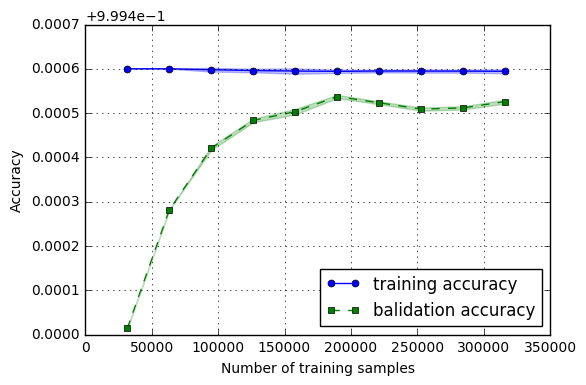

In [4]:
#分类器

from sklearn.ensemble import RandomForestClassifier
##建立模型
clf_1 = RandomForestClassifier()
#验证测试样本
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
clf_1.fit(X_train,y_train)
preditions=clf_1.predict(X_test)
#学习曲线
import numpy as np
from sklearn.model_selection import learning_curve
train_sizes,train_scores,test_scores=learning_curve(estimator=clf_1,
                                X=X_train,y=y_train,
                                train_sizes=np.linspace(0.1,1,10),
                                 cv=10, n_jobs=1,random_state=0)
train_mean=np.mean(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_std=np.std(train_scores,axis=1)
import matplotlib.pyplot as plt
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,
         color='blue',alpha=0.25)
plt.plot(train_sizes,test_mean,color='green',linestyle='--',
         marker='s',markersize=5,
         label='balidation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,
         color='green',alpha=0.25)
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

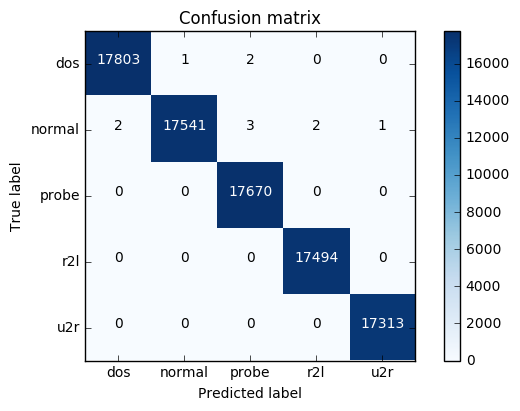

             precision    recall  f1-score   support

        dos   0.999888  0.999832  0.999860     17806
     normal   0.999943  0.999544  0.999744     17549
      probe   0.999717  1.000000  0.999859     17670
        r2l   0.999886  1.000000  0.999943     17494
        u2r   0.999942  1.000000  0.999971     17313

avg / total   0.999875  0.999875  0.999875     87832



In [4]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#混淆矩阵
import itertools
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test,preditions)
class_names=['dos','normal','probe','r2l','u2r']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix')
plt.show()
#分类报告
from sklearn.metrics import classification_report
class_names=['dos','normal','probe','r2l','u2r']
print(classification_report(y_test,preditions,target_names=class_names,digits=6))